In [1]:
# 표준 라이브러리
import os
import requests
from IPython.display import Image, display
# 서드파티 라이브러리
import streamlit as st
import openai
from dotenv import load_dotenv
import json
from typing import List, Annotated, Literal, Dict, Callable, TypeVar, Tuple, Type, Generic, Optional, Union, Any
from typing_extensions import TypedDict  # TypedDict를 typing_extensions에서 import



# LangChain 및 LangGraph 관련 라이브러리
from langchain_openai import OpenAI
from langchain_groq import ChatGroq
from langchain.prompts import PromptTemplate
from langchain.prompts.chat import ChatPromptTemplate, MessagesPlaceholder
from langchain.chains import LLMChain
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.language_models.chat_models import BaseChatModel
from langchain.agents import AgentExecutor
from langchain_community.agent_toolkits.polygon.toolkit import PolygonToolkit
from langchain_community.utilities.polygon import PolygonAPIWrapper
from langchain.tools import tool
from pydantic import BaseModel, Field
from typing import List, Dict, Optional

from langgraph.types import Command
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import create_react_agent
from langchain_community.tools.tavily_search import TavilySearchResults
from langsmith import utils 
from agents.agent_library import agent_configs, AgentConfig
from datetime import datetime, timedelta
from dateutil.parser import parse
import yfinance as yf
import pandas as pd
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate

from typing_extensions import TypedDict

from langgraph.types import Command
from sec_tool.sec_insider_trade_field_definitions import SEC_Insider_Trade_NecessaryFields
from sec_tool.sec_financial_fiedls_definitions import FinancialNecessaryFields
from sec_tool.insider_trade_tool import SECInsiderTradeAPI
from sec_tool.market_data_tool import MarketDataTools, FinancialDataTools


In [2]:
# 환경 변수 로드
load_dotenv()
print(utils.tracing_is_enabled())

True


In [3]:
class AgentState(MessagesState):
    initial_query: str


In [4]:
llm = ChatOpenAI(model="gpt-4o-mini-2024-07-18")

In [5]:
# 시장 조사 에이전트
news_and_sentiment_retrieval_agent = create_react_agent(
    llm, 
    tools=[MarketDataTools.get_stock_news, MarketDataTools.get_websearch_tool()],
    state_modifier='You are an expert in finding financial news and analyst opinions. Provide fact only not opinions'
)

def news_and_sentiment_retrieval_node(state: AgentState) -> Command[Literal["data_retrieval_leader"]]:
    """
    금융 뉴스 및 애널리스트 의견 수집

    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체

    Returns:
        Command: supervisor node로 이동하기 위한 명령을 반환
    """
    # 시장 조사 에이전트를 호출하여 결과를 얻습니다.
    result = news_and_sentiment_retrieval_agent.invoke(state)
    
    # 결과 메시지를 업데이트하고 supervisor node로 이동합니다.
    return Command(
        update={'messages': [HumanMessage(content=result['messages'][-1].content, name='news_and_sentiment_retrieval')]},
        goto='data_retrieval_leader'
    )



In [6]:
stock_research_tools = [MarketDataTools.get_stock_price]
stock_research_agent = create_react_agent(
    llm, tools=stock_research_tools, state_modifier='You are an expert in  market data retrieval. Your mission is to collect stock price information. Provide fact only not opinions'
)


def market_data_retrieval_node(state: AgentState) -> Command[Literal["data_retrieval_leader"]]:
    """
    실시간 주가 및 거래량 수집
    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체

    Returns:
        Command: supervisor node로 이동하기 위한 명령을 반환
    """
    result = stock_research_agent.invoke(state)

    return Command(
        update={'messages': [HumanMessage(content=result['messages'][-1].content, name='market_data_retrieval')]},
        goto='data_retrieval_leader'
    )




In [7]:
# 도구 리스트
financial_statement_retrieval_tools = [FinancialDataTools.get_income_statement, FinancialDataTools.get_financial_event_filings]

# 단일 에이전트 정의
financial_statement_retrieval_agent = create_react_agent(
    llm,
    tools=financial_statement_retrieval_tools,
    state_modifier='You are an expert in collecting corporate financial statements and performance data. Provide facts only, no opinions.'
)

def financial_statement_retrieval_node(state: AgentState) -> Command[Literal["data_retrieval_leader"]]:
    """
    회사 재무 보고서와 주요 사건 관련 자료를 조사하는 노드.
    손익계산서 데이터와 재무 및 주요 사건 관련 SEC 보고서를 처리합니다.

    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체

    Returns:
        Command: supervisor 노드로 이동하기 위한 명령을 반환
    """
    result = financial_statement_retrieval_agent.invoke(state)
    return Command(
        update={'messages': [HumanMessage(content=result['messages'][-1].content, name='financial_statement_retrieval')]},
        goto='data_retrieval_leader'
    )


In [8]:
analyst_prompt = PromptTemplate.from_template(
    """You are a stock market analyst. Given the following information, 
Please decide wheter to buy, sell, or hold the stock.

Information:
{messages}"""
)

analyst_chain = analyst_prompt | llm

def analyst_node(state: AgentState):
    """
    분석가 node

    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체

    Returns:
        dict: 분석 결과 메시지를 포함하는 딕셔너리를 반환
    """
    result = analyst_chain.invoke({'messages': state['messages'][1:]})

    return {'messages': [result]}

In [9]:

current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

insider_tracker_system_prompt = f"""You are an insider trading analyst.
You must provide factual data only, without any personal opinions or speculations.
The current time is {current_time}. Use this time when invoking tools that require the current time as an argument."""


insider_tracker_research_tools = [SECInsiderTradeAPI.fetch_filings]
insider_tracker_research_agent = create_react_agent(
    llm, tools=insider_tracker_research_tools, prompt=insider_tracker_system_prompt
)



def insider_tracker_research_node(state: AgentState) -> Command[Literal["data_retrieval_leader"]]:
    """
    내부자 거래 내역 조사 node 
    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체

    Returns:
        Command: supervisor node로 이동하기 위한 명령을 반환
    """
    result = insider_tracker_research_agent.invoke(state)

    return Command(
        update={'messages': [HumanMessage(content=result['messages'][-1].content, name='insider_tracker_research')]},
        goto='data_retrieval_leader'
    )



In [10]:
data_retrieval_team_members = ["news_and_sentiment_retrieval", "market_data_retrieval", "financial_statement_retrieval","insider_tracker_research"]
data_retrieval_options_for_next = data_retrieval_team_members + ["FINISH"]

data_retrieval_leader_system_prompt = (
    "You are a supervisor tasked with managing a conversation between the following specialized workers: {members}.\n"
    "Each worker handles specific tasks:\n"
    "- news_and_sentiment_retrieval: Handles news articles, market trends, general industry updates.\n"
    "- market_data_retrieval: Handles current stock prices\n"
    "- financial_statement_retrieval: Handles income statements, financial statements, and SEC filings.\n"
    "- insider_tracker_research: Handles insider trading filings and insider transactions.\n\n"
    "Given the user request, strictly select ONLY ONE most suitable worker to act next based on the task description above. "
    "When finished, respond with FINISH."
)



# ChatPromptTemplate 생성
data_retrieval_leader_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", data_retrieval_leader_system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next? "
            "Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(data_retrieval_options_for_next), members=", ".join(data_retrieval_team_members))


class DataTeamRouter(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*data_retrieval_options_for_next]



def data_retrieval_leader_node(state: AgentState) -> Command[Literal[*data_retrieval_team_members, "data_cleansing"]]:
    """
    supervisor node 
    주어진 State를 기반으로 각 worker의 결과를 종합하고,
    다음에 수행할 worker를 결정
    모든 작업이 완료되면 analyst node로 이동

    Args:
        state (AgentState): 현재 메시지 상태를 나타내는 객체

    Returns:
        Command: 다음에 수행할 worker 또는 analyst node로 이동하기 위한 명령 반환 
    """

    data_retrieval_team_chain = data_retrieval_leader_prompt | llm.with_structured_output(DataTeamRouter)
    response= data_retrieval_team_chain.invoke(state)

    goto = response["next"]
    if goto == "FINISH":
        goto = "data_cleansing"

    return Command(goto=goto)

In [11]:
analyst_prompt = PromptTemplate.from_template(
    """You are a stock market analyst. Given the following information, 
Please decide wheter to buy, sell, or hold the stock.

Information:
{messages}"""
)

analyst_chain = analyst_prompt | llm

def analyst_node(state: AgentState):
    """
    분석가 node

    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체

    Returns:
        dict: 분석 결과 메시지를 포함하는 딕셔너리를 반환
    """
    result = analyst_chain.invoke({'messages': state['messages'][1:]})

    return {'messages': [result]}

In [12]:
data_cleansing_system_prompt = (
    "You are a data cleansing agent responsible for refining raw data collected by the data team. "
    "Your role is to process the collected data to ensure it directly addresses the user's original question. "
    "Your tasks are: "
    "- Remove irrelevant or redundant information that does not help answer the user's question. "
    "- Fix inconsistencies (e.g., missing values, incorrect formats) to make the data usable. "
    "- Structure the data in a concise, clear format tailored to the user's request. "
    "Provide only factual, cleaned data without opinions or speculations. ")

# ChatPromptTemplate 생성
data_cleansing_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", data_cleansing_system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, "
            "Refine and process this data to align with the user's original questio : {initial_query}"
        )
    ]
)


def data_cleansing_node(state: AgentState) -> Command[Literal["supervisor"]]:
    """
    데이터 클렌징 노드. 수집된 데이터를 정제하여 supervisor로 전달

    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체

    Returns:
        dict: 분석 결과 메시지를 포함하는 딕셔너리를 반환
    """

    class CleanedData(BaseModel):
        relevant_data: str = Field(
            ..., description="사용자의 질문과 직접 연관이 있고, 중복 및 불필요한 정보가 제거된 정제된 데이터"
        )

    cleaning_chain = data_cleansing_prompt | llm.with_structured_output(CleanedData)
    result = cleaning_chain.invoke({"messages" : state['messages'], "initial_query" : state["messages"][0].content})

    return Command(
        update={'messages': [HumanMessage(content=result.relevant_data, name='data_cleansing')]},
        goto='supervisor'
    )

In [13]:
supervisor_members = ["data_retrieval_leader"]
supervisor_options_for_next = supervisor_members + ["FINISH"]

supervisor_system_prompt = (
    "You are a supervisor tasked with managing a conversation between the following specialized workers: {members}.\n"
    "Each worker handles specific tasks:\n"
    "- 'data_team_leader':  role is responsible for collecting and refining the data required to answer user questions.\n"
    "Given the user request, strictly select ONLY ONE most suitable worker to act next based on the task description above. "
    "When finished, respond with FINISH."
)



# ChatPromptTemplate 생성
supervisor_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", supervisor_system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next? "
            "Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(supervisor_options_for_next), members=", ".join(supervisor_members))


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*supervisor_options_for_next]



def supervisor_node(state: AgentState) -> Command[Literal[*supervisor_members, "analyst"]]:
    """
    supervisor node 
    주어진 State를 기반으로 각 worker의 결과를 종합하고,
    다음에 수행할 worker를 결정
    모든 작업이 완료되면 analyst node로 이동

    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체

    Returns:
        Command: 다음에 수행할 worker 또는 analyst node로 이동하기 위한 명령 반환 
    """

    supervisor_chain = supervisor_prompt | llm.with_structured_output(Router)
    response= supervisor_chain.invoke(state)

    goto = response["next"]
    if goto == "FINISH":
        goto = "analyst"

    return Command(goto=goto)

In [14]:
graph_builder = StateGraph(AgentState)

graph_builder.add_node("supervisor", supervisor_node)
graph_builder.add_node("news_and_sentiment_retrieval", news_and_sentiment_retrieval_node)
graph_builder.add_node("market_data_retrieval", market_data_retrieval_node)
graph_builder.add_node("financial_statement_retrieval", financial_statement_retrieval_node)
graph_builder.add_node("insider_tracker_research", insider_tracker_research_node)
graph_builder.add_node("analyst", analyst_node)
graph_builder.add_node("data_retrieval_leader", data_retrieval_leader_node)
graph_builder.add_node("data_cleansing", data_cleansing_node)

graph_builder.add_edge(START, "supervisor")
graph_builder.add_edge("analyst", END)
graph = graph_builder.compile()



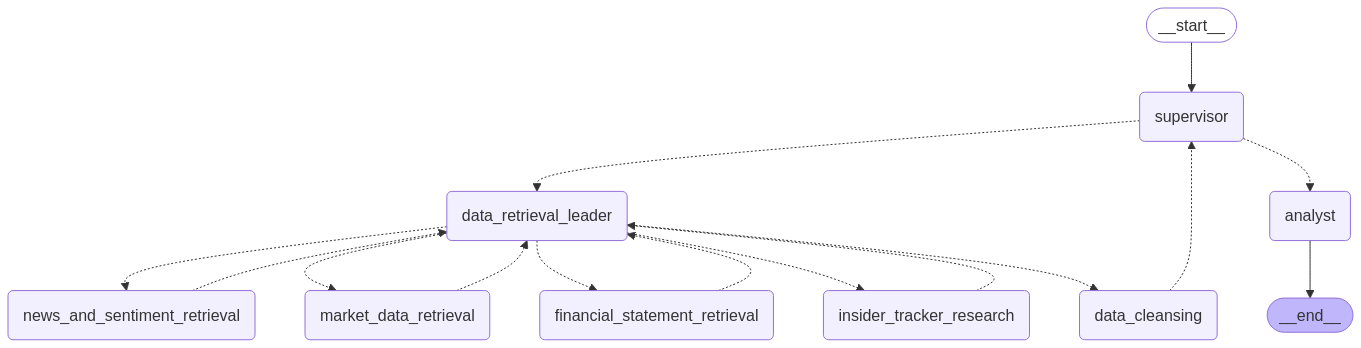

In [15]:
graph

In [ ]:
for chunk in graph.stream(
    {"messages": [("user", "최근 한달간 테슬라 내부자 거래가 있었는지 확인해줘")]}, stream_mode="values"
):
    chunk['messages'][-1].pretty_print()

In [ ]:
initial_query="24년 1월에 테슬라를 매도한 내부자가 있나?"
for chunk in graph.stream(
    {"messages": [("user", initial_query)], "initial_query" : initial_query}, stream_mode="values"
    ):
    chunk['messages'][-1].pretty_print()

In [16]:
initial_query= "오늘 테슬라 주가가 얼마냐"
for chunk in graph.stream(
    {"messages": [("user", initial_query)]}, stream_mode="values"
    ):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

오늘 테슬라 주가가 얼마냐
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


================================ Human Message =================================
Name: market_data_retrieval

오늘 테슬라(TSLA)의 주가는 다음과 같습니다:

- 종가: $235.86
- 시가: $231.61
- 고가: $241.41
- 저가: $229.20
- 거래량: 111,250,900 주
================================ Human Message =================================
Name: data_cleansing

오늘 테슬라(TSLA) 주가는 $235.86입니다.
================================== Ai Message ==================================

To determine whether to buy, sell, or hold Tesla's (TSLA) stock based on the provided information, we'll analyze a few key points:

1. **Current Price Analysis**:
   - Current closing price: $235.86
   - Open price: $231.61
   - High price: $241.41
   - Low price: $229.20

2. **Price Movement**:
   - The stock opened lower at $231.61 and has risen to $235.86, showing positive momentum for the day.
   - The high of the day was $241.41, which indicates that there was potential for the stock to move higher within the session.

3. **Trading Volume**:
   - The trading 

In [20]:
for chunk in graph.stream(
    {"messages": [("user", "최근 한달간 테슬라 평균 종가 가격은 얼마냐?")]}, stream_mode="values"
):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

최근 한달간 테슬라 평균 종가 가격은 얼마냐?
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


================================ Human Message =================================
Name: market_data_retrieval

최근 한달간 테슬라(TSLA)의 종가 데이터는 다음과 같습니다:

- 2025-02-19: 360.56
- 2025-02-20: 354.40
- 2025-02-21: 337.80
- 2025-02-24: 330.53
- 2025-02-25: 302.80
- 2025-02-26: 290.80
- 2025-02-27: 281.95
- 2025-02-28: 292.98
- 2025-03-03: 284.65
- 2025-03-04: 272.04
- 2025-03-05: 279.10
- 2025-03-06: 263.45
- 2025-03-07: 262.67
- 2025-03-10: 222.15
- 2025-03-11: 230.58
- 2025-03-12: 248.09
- 2025-03-13: 240.68
- 2025-03-14: 249.98
- 2025-03-17: 238.01
- 2025-03-18: 225.31

평균 종가는 (360.56 + 354.40 + 337.80 + 330.53 + 302.80 + 290.80 + 281.95 + 292.98 + 284.65 + 272.04 + 279.10 + 263.45 + 262.67 + 222.15 + 230.58 + 248.09 + 240.68 + 249.98 + 238.01 + 225.31) / 20 = 약  274.24입니다.
================================== Ai Message ==================================

Based on the provided closing price data for Tesla (TSLA) over the past month, we observe a significant downward trend. The stock started at a

In [14]:
for chunk in graph.stream(
    {"messages": [("user", "테슬라 관련된 뉴스 찾아줘")]}, stream_mode="values"
):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

테슬라 관련된 뉴스 찾아줘
================================ Human Message =================================
Name: market_research

Here are the latest news articles related to Tesla (TSLA):

1. **[Tesla Stock: Did We Just See the Bottom?](https://www.fool.com/investing/2025/03/17/tesla-stock-did-we-just-see-the-bottom/?source=iedfolrf0000001)**  
   - **Publisher:** The Motley Fool  
   - **Published:** March 17, 2025  
   - **Summary:** Discusses recent performance of Tesla stock, noting a significant drop but suggesting potential for a substantial rebound according to a Wall Street expert.
   - **Keywords:** Tesla, stock performance, market cap  

2. **[US Stocks Likely To Open Lower As Futures Decline: 'Stay Calm And Stick With Your Long-Term Plan,' Says Expert Amid Correction Woes](https://www.benzinga.com/25/03/44351741/us-stocks-likely-to-open-lower-as-futures-decline-stay-calm-and-stick-with-your-long-term-pla

In [19]:
for chunk in graph.stream(
    {"messages": [("user", "최근 테슬라 주가 흐름과 테슬라 주가에 영향을 주고있는 이슈를 찾아봐")]}, stream_mode="values"
):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

최근 테슬라 주가 흐름과 테슬라 주가에 영향을 주고있는 이슈를 찾아봐
================================ Human Message =================================
Name: news_and_sentiment_retrieval

### 최근 테슬라 주가 흐름
- **주가 하락**: 테슬라 주가는 2025년 동안 36% 하락했습니다. 하지만 지난 12개월 동안은 54% 상승했습니다.
- **최근 움직임**: 최근 주가는 하루에 7% 하락한 후 5% 하락으로 거래를 마감했습니다. 현재 주가는 약 224.19달러입니다.

### 테슬라 주가에 영향을 주고 있는 이슈
1. **칼리포니아 운송 서비스 허가**:
   - 테슬라는 칼리포니아에서 운송 서비스를 운영할 수 있는 허가를 받았으며, 이는 향후 로봇택시 서비스 운영에 긍정적인 영향을 미칠 것으로 예상됩니다. [전체 기사](https://techcrunch.com/2025/03/18/what-tesla-can-and-cant-do-in-california-with-its-new-passenger-transportation-permit/)

2. **BYD의 EV 충전 시스템**:
   - BYD가 새로운 EV 충전 시스템을 발표하면서 테슬라에 대한 경쟁 압력이 증가하고 있습니다. 이에 따라 테슬라 주가는 추가 하락세를 보이고 있습니다. [전체 기사](https://finance.yahoo.com/video/byd-unveils-ev-charging-system-135200599.html)

3. **델라웨어에서의 주주 소송 문제**:
   - 델라웨어에서 주주 소송을 둘러싼 법안이 논의되고 있으며, 이번 이슈는 테슬라의 비즈니스 환경에 영향을 미칠 수 있습니다. [전체 기사](https://finance.yahoo.com